In [1]:
import yfinance as yf
from datetime import timedelta, datetime
import mplfinance as mpf
import pandas as pd
from numpy import trapz,nan
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical 

In [2]:
def compute_ichimoku(df_stock):
    #Tenkan Sen
    tenkan_max = df_stock['High'].rolling(window = 9, min_periods = 0).max()
    tenkan_min = df_stock['Low'].rolling(window = 9, min_periods = 0).min()
    df_stock['tenkan_avg'] = (tenkan_max + tenkan_min) / 2

    #Kijun Sen
    kijun_max = df_stock['High'].rolling(window = 26, min_periods = 0).max()
    kijun_min = df_stock['Low'].rolling(window = 26, min_periods = 0).min()
    df_stock['kijun_avg'] = (kijun_max + kijun_min) / 2

    df_stock['senkou_a'] = ((df_stock['kijun_avg'] + df_stock['tenkan_avg']) / 2).shift(26)

    #Senkou Span B
    #52 period High + Low / 2
    senkou_b_max = df_stock['High'].rolling(window = 52, min_periods = 0).max()
    senkou_b_min = df_stock['Low'].rolling(window = 52, min_periods = 0).min()
    df_stock['senkou_b'] = ((senkou_b_max + senkou_b_min) / 2).shift(52)

    #Chikou Span
    #Current close shifted -26
    df_stock['chikou'] = (df_stock['Close']).shift(-26)

    return df_stock

In [3]:
def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth


In [4]:
rf_parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
}

test_period = 180

In [5]:
ticker = yf.Ticker('IPAR')
df_stock = ticker.history('2y')

df_stock['Date'] = df_stock.index.values
df_stock = compute_ichimoku(df_stock)
df_stock = df_stock.drop(['chikou', 'Dividends', 'Stock Splits'], axis=1).dropna()
df_stock['cloud_avg_dist'] = (df_stock['senkou_a'] + df_stock['senkou_b']) / 2 - df_stock['Close']
df_stock['base_lines_avg_dist'] = (df_stock['tenkan_avg'] + df_stock['kijun_avg']) / 2 - df_stock['Close']
df_stock['kijun_dist'] = df_stock['kijun_avg'] - df_stock['Close']
df_stock['tenkan_dist'] = df_stock['tenkan_avg'] - df_stock['Close']
df_stock['senkou_a_dist'] = df_stock['senkou_a'] - df_stock['Close']
df_stock['senkou_b_dist'] = df_stock['senkou_b'] - df_stock['Close']
df_stock['senkou_range'] = df_stock['senkou_a'] - df_stock['senkou_b']
df_stock['baseline_range'] = df_stock['tenkan_avg'] - df_stock['kijun_avg']
df_stock['high_low_difference'] = df_stock['High'] - df_stock['Low']
df_stock['adx'] = pd.DataFrame(get_adx(df_stock['High'], df_stock['Low'], df_stock['Close'], 14)[2]).rename(columns = {0:'adx'})
df_stock['surface'] = nan
df_stock['slope_tenkan'] = nan
df_stock['slope_kijun'] = nan
#plt.plot(df_stock['high_low_difference'])
#print(df_stock)

In [6]:
first_entry = df_stock.head(1)
last_order = first_entry['tenkan_avg'] < first_entry['kijun_avg']
border_dates = []
for index, row in df_stock.iterrows():
    new_order = row['tenkan_avg'] < row['kijun_avg']
    if new_order is not last_order:
        border_dates.append(row['Date'])

    last_sell_line = row['tenkan_avg']
    last_buy_line = row['kijun_avg']
    last_order = last_sell_line < last_buy_line

border_dates.append(df_stock['Date'].iloc[-1])
border_dates.pop(0)


date_intervals = []
for index in range(len(border_dates)-1):
    date_intervals.append((border_dates[index], border_dates[index+1]))

In [7]:
for interval in date_intervals:
    interval_df_stock = df_stock[(df_stock['Date'] >= interval[0]) & (df_stock['Date'] <= interval[1])]
    for index, entry in interval_df_stock.iterrows():
        entry_interval_df_stock = interval_df_stock[interval_df_stock['Date'] <= entry['Date']]
        interval_buy_line = entry_interval_df_stock['tenkan_avg']
        interval_sell_line = entry_interval_df_stock['kijun_avg']

        buy_area_interval = trapz(interval_buy_line, dx=1)
        sell_area_interval = trapz(interval_sell_line, dx=1)

        area_between_lines_interval = buy_area_interval - sell_area_interval
        df_stock.at[index,'surface'] = area_between_lines_interval

In [8]:
for index, entry in df_stock.iterrows():
    current_date = entry['Date']
    intermediary_df_stock = df_stock[df_stock['Date']<=current_date]
    slope_sell = None
    slope_buy = None
    interval_buy_line = intermediary_df_stock['tenkan_avg']
    interval_sell_line = intermediary_df_stock['kijun_avg']
    if len(interval_sell_line) > 2 and len(interval_buy_line) > 2:
        x1_sell,y1_sell = 1, interval_sell_line[-2]
        x2_sell,y2_sell = 2, interval_sell_line[-1]
        slope_sell = ((y2_sell-y1_sell)/(x2_sell-x1_sell))
        x1_buy,y1_buy = 1, interval_buy_line[-2]
        x2_buy,y2_buy = 2, interval_buy_line[-1]
        slope_buy = ((y2_buy-y1_buy)/(x2_buy-x1_buy))

    df_stock.at[index,'slope_tenkan'] = slope_buy
    df_stock.at[index,'slope_kijun'] = slope_sell


In [9]:
df_stock = df_stock.dropna()
print(df_stock)

                                 Open        High         Low       Close  \
Date                                                                        
2021-07-26 00:00:00-04:00   72.789927   74.940731   72.789927   74.419914   
2021-07-27 00:00:00-04:00   73.889447   74.554946   72.471648   73.069633   
2021-07-28 00:00:00-04:00   73.436136   73.976248   72.172659   73.706192   
2021-07-29 00:00:00-04:00   74.043762   74.362045   72.153366   73.195015   
2021-07-30 00:00:00-04:00   73.156431   74.371688   72.481292   74.140213   
...                               ...         ...         ...         ...   
2023-04-17 00:00:00-04:00  147.070007  150.729996  146.889999  149.839996   
2023-04-18 00:00:00-04:00  149.710007  151.449997  148.809998  149.419998   
2023-04-19 00:00:00-04:00  149.539993  151.610001  148.330002  151.559998   
2023-04-20 00:00:00-04:00  152.850006  161.169998  152.850006  157.589996   
2023-04-21 00:00:00-04:00  158.490005  160.289993  158.050003  158.660004   

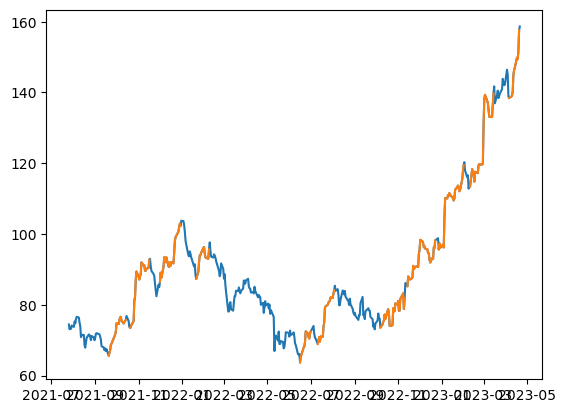

In [10]:
window_check_interval = 30
start_index = 0
df_stock['signal'] = 0
while(start_index < len(df_stock)):
    df_stock_filtered_interval = df_stock.iloc[start_index:start_index + window_check_interval]
    minimum_price = min(df_stock_filtered_interval['Close'])
    maximum_price = max(df_stock_filtered_interval['Close'])
    if maximum_price >= 1.1 * minimum_price:
        maximum_date = df_stock_filtered_interval.loc[df_stock_filtered_interval['Close'] == maximum_price, 'Date'].values[0]
        minimum_date = df_stock_filtered_interval.loc[df_stock_filtered_interval['Close'] == minimum_price, 'Date'].values[0]
        

        if maximum_date > minimum_date:
            df_stock.loc[(df_stock['Date'] >= minimum_date) & (df_stock['Date'] < maximum_date), 'signal'] = 1
        

    start_index += window_check_interval
plot_buy = []
x_values = []
for index, entry in df_stock.iterrows():
    if entry['signal']:
        plot_buy.append(entry['Close'])
    else:
        plot_buy.append(None)
    x_values.append(index)
plt.plot(df_stock['Close'])
plt.plot(x_values,plot_buy)
plt.show()


Stock finder

In [11]:
# stocks = ['NVDA', 'AAPL', 'UNH', 'FDX', 'TSLA', 'XOM', 'JPM', 'V', 'PG', 'HD', 'MRK', 'RACE', 'WMT', 'BAC', 'CRM', 'QCOM', 'AMD', 'NKE', 'IPAR', 'TEAM' ]

# for stock in stocks:
#     ticker = yf.Ticker(stock)
#     df_stock = ticker.history('2y')

#     df_stock['Date'] = df_stock.index.values

#     window_check_interval = 30
#     start_index = 0
#     df_stock['signal'] = 0
#     while(start_index < len(df_stock)):
#         df_stock_filtered_interval = df_stock.iloc[start_index:start_index + window_check_interval]
#         minimum_price = min(df_stock_filtered_interval['Close'])
#         maximum_price = max(df_stock_filtered_interval['Close'])
#         if maximum_price >= 1.1 * minimum_price:
#             maximum_date = df_stock_filtered_interval.loc[df_stock_filtered_interval['Close'] == maximum_price, 'Date'].values[0]
#             minimum_date = df_stock_filtered_interval.loc[df_stock_filtered_interval['Close'] == minimum_price, 'Date'].values[0]
            

#             if maximum_date > minimum_date:
#                 df_stock.loc[(df_stock['Date'] >= minimum_date) & (df_stock['Date'] < maximum_date), 'signal'] = 1
            

#         start_index += window_check_interval
#     plot_buy = []
#     x_values = []
#     for index, entry in df_stock.iterrows():
#         if entry['signal']:
#             plot_buy.append(entry['Close'])
#         else:
#             plot_buy.append(None)
#         x_values.append(index)
#     print(stock)
#     plt.plot(df_stock['Close'])
#     plt.plot(x_values,plot_buy)
#     plt.show()

439


C:\Users\George\AppData\Local\Temp\ipykernel_8364\831364054.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_filtered[ncn] = (df_stock_filtered[ncn] - df_stock_filtered[ncn].min())/(df_stock_filtered[ncn].max()-df_stock_filtered[ncn].min())


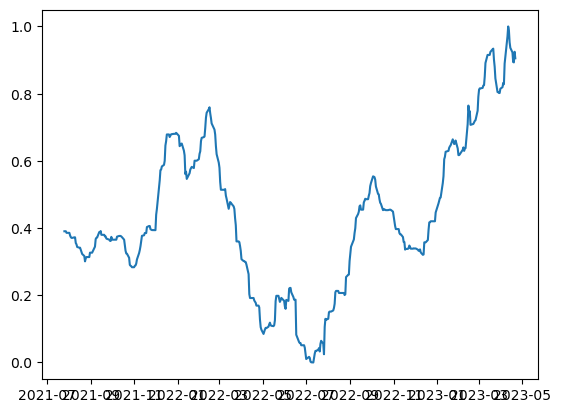

In [12]:
df_stock_filtered = df_stock[['Date', 'Volume', 'adx', 'cloud_avg_dist', 'base_lines_avg_dist', 'senkou_range', 'baseline_range', 'high_low_difference', 'kijun_dist', 'tenkan_dist', 'senkou_a_dist', 'senkou_b_dist', 'surface', 'slope_tenkan', 'slope_kijun', 'signal']]

# ncn -> normalize column names
ncn = ['Volume', 'cloud_avg_dist', 'adx', 'base_lines_avg_dist', 'kijun_dist', 'senkou_range', 'baseline_range', 'high_low_difference', 'tenkan_dist', 'senkou_a_dist', 'senkou_b_dist', 'surface', 'slope_tenkan', 'slope_kijun']


print(len(df_stock_filtered))
# df_chunks = np.array_split(df_stock_filtered, 3)


# for index in range(len(df_chunks)):
#     df_chunks[index][ncn] = (df_chunks[index][ncn] - df_chunks[index][ncn].min())/(df_chunks[index][ncn].max()-df_chunks[index][ncn].min())

# df_stock_filtered = pd.concat(df_chunks)

df_stock_filtered[ncn] = (df_stock_filtered[ncn] - df_stock_filtered[ncn].min())/(df_stock_filtered[ncn].max()-df_stock_filtered[ncn].min())


plt.plot(df_stock_filtered['senkou_range'])
plt.show()


In [13]:
Y = df_stock_filtered['signal']
X = df_stock_filtered.drop(['signal', 'Date'], axis=1)

Y_train = Y[0:720]
X_train = X[:720]
y_test_report = Y[-test_period:]
X_test = X[-test_period:]
Y_test = to_categorical(y_test_report)
Y_train = to_categorical(Y_train)

In [14]:
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
# es = EarlyStopping(monitor='val_accuracy', 
#                                    mode='max', # don't minimize the accuracy!
#                                    patience=10,
#                                    restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train,
                    Y_train,
                    epochs=150, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=False,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3840      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 45,122
Trainable params: 45,122
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
36/36 [==============================] - 1s 9ms/step - loss: 0.7013 - accuracy: 0.5527 - val_loss: 0.7716 - val_accuracy: 0.2614
Epoch 2/150
36/36 [========================

In [15]:
Y_pred = model.predict(X_test)
print(Y_pred)

prediction_list = [np.where(item == max(item)) for item in Y_pred]

final_prediction_list = [item[0][0] for item in prediction_list]
print(final_prediction_list)
print(classification_report(final_prediction_list, y_test_report))

scores2 = model.evaluate(X_test, Y_test, verbose=0)
print(scores2[1])

6/6 [==============================] - 0s 1ms/step
[[9.36560273e-01 6.34397417e-02]
 [9.99672353e-01 3.27639573e-04]
 [9.99751329e-01 2.48582510e-04]
 [9.99938786e-01 6.10968200e-05]
 [9.99999940e-01 2.06513686e-08]
 [9.99648988e-01 3.50904418e-04]
 [9.99770641e-01 2.29249068e-04]
 [9.96851385e-01 3.14865145e-03]
 [9.98601735e-01 1.39829016e-03]
 [9.99216974e-01 7.82962947e-04]
 [9.94778156e-01 5.22188935e-03]
 [9.99277413e-01 7.22642231e-04]
 [9.98069942e-01 1.93009106e-03]
 [9.99423146e-01 5.76902530e-04]
 [9.99945104e-01 5.48236203e-05]
 [9.99830484e-01 1.69663937e-04]
 [9.99981225e-01 1.86994057e-05]
 [9.99990165e-01 9.76619867e-06]
 [9.99936402e-01 6.34777971e-05]
 [9.99946892e-01 5.30771031e-05]
 [9.99864340e-01 1.35779235e-04]
 [9.99922097e-01 7.78659087e-05]
 [9.99926507e-01 7.34866408e-05]
 [9.99707460e-01 2.92423385e-04]
 [9.99607265e-01 3.92661517e-04]
 [9.52035546e-01 4.79644164e-02]
 [1.20190093e-02 9.87980962e-01]
 [9.99808788e-01 1.91208572e-04]
 [9.99441087e-01 5.589558

In [16]:
df_test_profit = df_stock.tail(test_period)
df_test_profit['signal'] = final_prediction_list
buy_transaction_plot = []
sell_transaction_plot = []
x_values =[]
for index, entry in df_test_profit.iterrows():
    if entry['signal'] == 1:
        buy_transaction_plot.append(entry['Close']) #if entry['tenkan_avg'] > entry['kijun_avg'] else buy_transaction_plot.append(None)
    else:
        buy_transaction_plot.append(None)
    x_values.append(index)
    

C:\Users\George\AppData\Local\Temp\ipykernel_8364\4051728112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_profit['signal'] = final_prediction_list


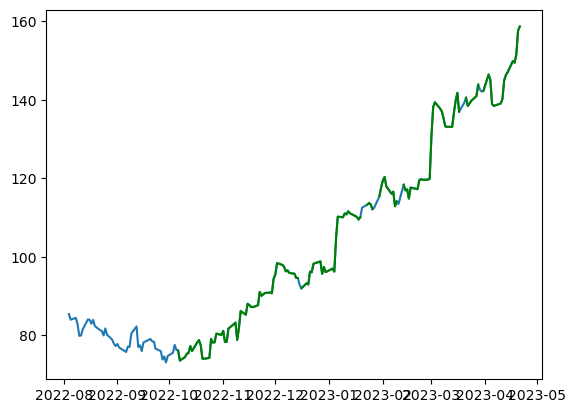

In [17]:
# add_plots= [
#             mpf.make_addplot(df_test_profit['kijun_avg']),
#             mpf.make_addplot(df_test_profit['tenkan_avg']),
#             #mpf.make_addplot(df_stock.tail(365)['adx'], color='red'),
#             #mpf.make_addplot(signals[-250:],type='scatter',markersize=200,marker='^'),
#             mpf.make_addplot(buy_transaction_plot , color = 'green'),
#             mpf.make_addplot(sell_transaction_plot, color = 'red'),
#            ]

# mpf.plot(df_test_profit, type = 'candle', volume = True, ylabel = "Price", ylabel_lower  = 'Volume', style = 'nightclouds', figratio=(15,10), figscale = 1.5,  addplot = add_plots)
plt.plot(x_values, df_test_profit['Close'])
# plt.plot(x_values,df_test_profit['tenkan_avg'], )
# plt.plot(x_values,df_test_profit['kijun_avg'], color = 'yellow')
plt.plot(x_values,buy_transaction_plot, color='green')

plt.show()

In [18]:
start_buy_price = None
start_sell_price = None
stop_buy_price = None
stop_sell_price = None
profits = []
counter = 0
for index, entry in df_test_profit.iterrows():
    
    if entry['signal'] == 1 and start_buy_price is None:
        start_buy_price = entry['Close']

    if entry['signal'] == 0 and start_buy_price is not None and stop_buy_price is None:
        stop_buy_price = entry['Close']

    
    if start_buy_price and stop_buy_price:
        profit = ((stop_buy_price/start_buy_price) * 100) - 100
        profits.append(profit)
        start_buy_price = None
        stop_buy_price = None

initial_sum = 100
for profit in profits:
    initial_sum += initial_sum*(profit/100) if profit else 0
print(profits)
print(initial_sum-100)

[-6.341243805117429, 21.97856904149056, 22.355730511568765, -0.7030535689662116, -1.7248848381102846, 17.64696099229357, 1.4802175973619285]
62.8537607728133
